# NLP analysis of movie plots: building classic models

With clean data we can start fitting models and comparing their performance.

## 0. Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

#removing warnings
import warnings
warnings.filterwarnings("ignore")

#preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import PolynomialFeatures

#building models
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier, XGBRegressor

## 1. Loading data

In [2]:
with open('data/X.p', 'rb') as f:
    X = pickle.load(f)

with open('data/y.p', 'rb') as f:
    y = pickle.load(f)

With raw data we found that the distribution of the plot length has two peaks and that short plot description can bring bias to the analysis. That's why we need build distribution again (after cleaning the data) and cut off too short instances.

<AxesSubplot:ylabel='Frequency'>

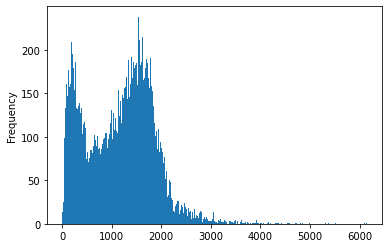

In [3]:
X.apply(len).plot(kind='hist', bins = 500)

Look's like 500 would be a nice cut off value.

In [4]:
y = y[X.apply(len)>=500]
X = X[X.apply(len)>=500]
len(X)

18057

We lost some data but still have 18k movie descriptions. Now we can split the sample and start building models.

## 2. Splitting data into train and test samples

We are splitting the data into train and test. No need for validation set as we have small sample. We will use crossvalidation for tuning hyperparameters if needed.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1234, shuffle = True)

print('Train sample size: '+str(len(y_train)))
print('Test sample size: '+str(len(y_test)))

Train sample size: 13542
Test sample size: 4515


## 3. Linear Regression

Let's start with classical linear regression. As we are not sure what ngram vectorization use, we are using grid search to tune hyperparameters as max_df and min_df. We will evaluate which model gives the smallest r2 estimate and test it on test sample.

In [6]:
def fit_reg_model(pipeline, param_grid):
    grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, verbose = 3, scoring = 'r2')
    grid_search.fit(X_train, y_train)
    print("Best parameter: "+str(grid_search.best_params_))
    print("Train sample R2: "+str(grid_search.score(X_train, y_train)))
    print("Test sample R2: "+str(grid_search.score(X_test, y_test)))
    
    y_pred = grid_search.predict(X_test)
    plt.figure(figsize = (6,6))
    plt.scatter(x=y_test, y = y_pred, marker = 'x')
    plt.plot(y_test,y_test, color = 'r')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.title('Plotting true values against predicted')
    plt.show()

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameter: {'vect__max_df': 4500, 'vect__min_df': 550, 'vect__ngram_range': (1, 1)}
Train sample R2: 0.16085799705658266
Test sample R2: 0.10085348385629067


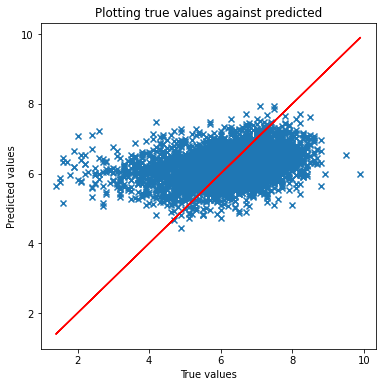

In [7]:
pipeline = Pipeline([('vect', CountVectorizer(binary = True, stop_words='english')),
                     ('lin_reg', LinearRegression())])

param_grid = {"vect__ngram_range":[(1,1),(1,2)],
              "vect__max_df":[4000, 4500, 5000],
              "vect__min_df":[500, 550, 600],}

fit_reg_model(pipeline, param_grid)

We can see that the linear regression is not a good fit for the data. Mostly the model predicts average value of the ratings - around 6. Let's look at the largest and smallest coefficients.

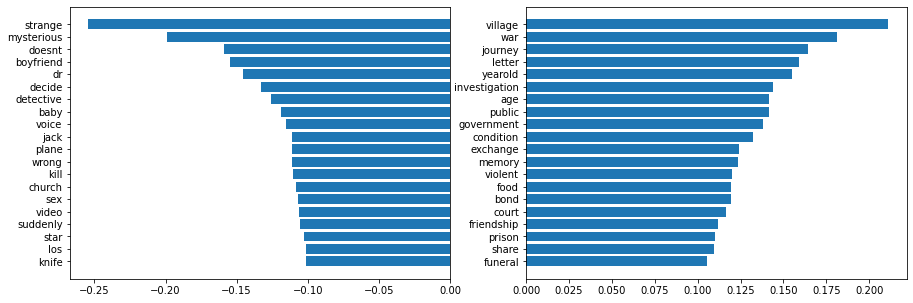

In [8]:
#retrain the model with the best parameters
pipeline = Pipeline([('vect', CountVectorizer(binary = True, stop_words='english', max_df = 4500, min_df = 550, 
                                              ngram_range=(1, 1))),
                     ('lin_reg', LinearRegression())])

pipeline.fit(X_train, y_train)

#plotting coefficients - 20 top and 20 bottom
coefficients = pd.DataFrame({'feat_name':pipeline['vect'].get_feature_names_out(),'coefs':pipeline['lin_reg'].coef_})
bottom = coefficients.sort_values(by = 'coefs', ascending = False).tail(20).set_index('feat_name')
top = coefficients.sort_values(by = 'coefs').tail(20).set_index('feat_name')

fig, axs = plt.subplots(1,2, figsize = (15,5))
axs[0].barh(bottom.index, bottom['coefs'])
axs[1].barh(top.index, top['coefs'])
plt.show()

Some of the words do not make a lot of sense. We can point out some intereseting features. We have among words indicating highly rated movies: `war`, `government`, `investigation`,`prison` and `funeral`. Sounds like an action movie or documentary. On the other side, we have `strange`, `mysterious`, `kill` and `church`. These words can be seen in the horror movie description, which makes sense since horror movies are ususally low rated. Nevertheless, we cannot dive into further analysis since the model is a poor fit.

## 4. Classification

Let's try reformulating the problem into classification. The main problem is that splitting the target value - ratings - into halves will give us high error rate. For example, we need our model to classify 6.6 rated movie as good one while 6.4 as bad one which hardly achievable. So we will try identifying highly rated movies (more than 7.5) and then low rated movies (lower than 5.5)

We try training classification models like naive bayes, logistic regression, random forest and xgboost classifier. We compare the results and further analyze the best model coefficients/feature importance.

### 4.1 Highly rated movies

In [9]:
y_bin = [1 if x >= 7.5 else 0 for x in y]
sum(y_bin)

2063

We are binarizing our model: highly rated movies and others. We end up with 2k highly rated movies which makes our data unbalanced.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, random_state = 1234, shuffle = True, stratify = y_bin)

print('Train sample size: '+str(len(y_train)))
print('Test sample size: '+str(len(y_test)))

Train sample size: 13542
Test sample size: 4515


Let's vectorize data using (1,1)-gram vectorization. We are not afraid to violate independence assumption since the minimum document frequency is high - 550. Hyperparameters were taken from the regression model to reduce time of training models.

In [11]:
vectorizer = CountVectorizer(binary = True, stop_words='english', max_df = 4500, min_df = 550, ngram_range=(1,1))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
print("Number of features: " + str(len(vectorizer.get_feature_names_out())))

Number of features: 503


Number of features is 503 which is smaller than train sample size - important condition for classical model convergence.

In [12]:
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted) 
    
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted)
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted)
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [13]:
def fit_class_model(model, param_grid):
    clf = GridSearchCV(model, param_grid, n_jobs=-1, verbose = 3, scoring = 'recall')
    clf.fit(X_train, y_train)
    print("Best parameter: "+str(clf.best_params_))
    
    y_train_pred = clf.predict(X_train)
    accuracy, precision, recall, f1 = get_metrics(y_train, y_train_pred)
    print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
    
    y_test_pred = clf.predict(X_test)
    accuracy, precision, recall, f1 = get_metrics(y_test, y_test_pred)
    print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
    
    fig, axs = plt.subplots(1,2, figsize = (10,4))
    cf_matrix = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(cf_matrix, annot=True, fmt='.0f',cmap='Blues', ax = axs[0])
    axs[0].set_title("Confusion matrix for train sample")
    
    cf_matrix = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cf_matrix, annot=True, fmt = '.0f', cmap='Blues', ax = axs[1])
    axs[1].set_title("Confusion matrix for test sample")
    plt.show()

We are using recall as main metric to get high rate of predicted positives. We want to decrease number of false negatives as movies with bad plot are less likely to end up with high ratings while good plots can be bad movies as other factors are involved.

### 4.1.1 Naive Bayes

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameter: {'alpha': 0.1}
accuracy = 0.850, precision = 0.328, recall = 0.297, f1 = 0.312
accuracy = 0.838, precision = 0.253, recall = 0.215, f1 = 0.232


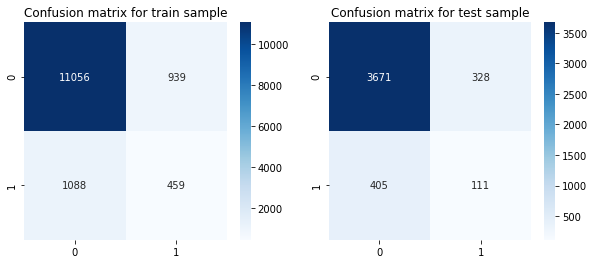

In [14]:
naive_b = BernoulliNB()

param_grid = {"alpha": [1, 0.1, 0.01, 0.001]}

fit_class_model(naive_b, param_grid)

### 4.1.2 Logistic regression

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameter: {'C': 0.001}
accuracy = 0.682, precision = 0.215, recall = 0.671, f1 = 0.325
accuracy = 0.657, precision = 0.179, recall = 0.556, f1 = 0.270


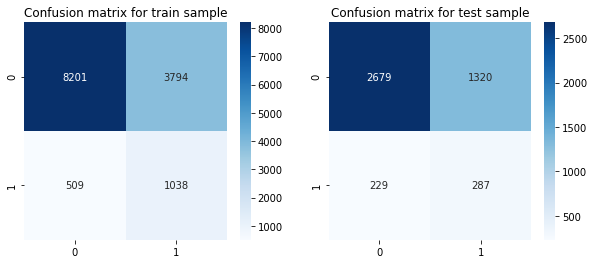

In [15]:
log_reg = LogisticRegression(class_weight = 'balanced')

param_grid = {"C": [0.001, 0.01, 0.1, 1]
}
fit_class_model(log_reg, param_grid)

### 4.1.3 Random forest classifier

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameter: {'max_depth': 200}
accuracy = 0.985, precision = 0.886, recall = 0.995, f1 = 0.937
accuracy = 0.871, precision = 0.151, recall = 0.027, f1 = 0.046


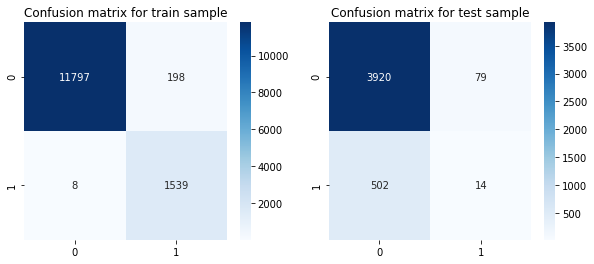

In [16]:
rfc = RandomForestClassifier(n_estimators = 200, class_weight = 'balanced')

param_grid = {"max_depth": [200, 300, 400]}

fit_class_model(rfc, param_grid)

### 4.1.4 XGBoost classifier

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[00:58:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:58:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameter: {'max_depth': 200}
accuracy = 0.987, precision = 0.960, recall = 0.923, f1 = 0.941
accuracy = 0.867, precision = 0.180, recall = 0.047, f1 = 0.074


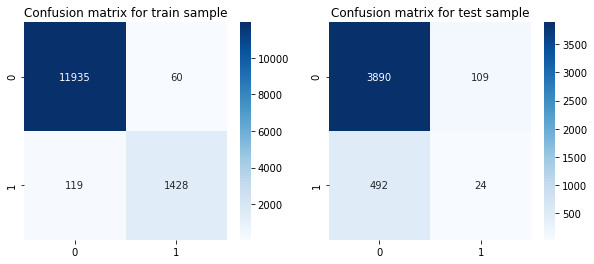

In [17]:
class_weights = compute_sample_weight('balanced', y_train)

xgb = XGBClassifier(n_estimators = 200, subsample = 0.6, sample_weight = class_weights)

param_grid = {"max_depth": [200, 300, 400]}

fit_class_model(xgb, param_grid)

### 4.1.5 Important features

We got the best result from logistic model. The ensemble models are obviously overfitting. Now we can look into logistic regression coefficients.

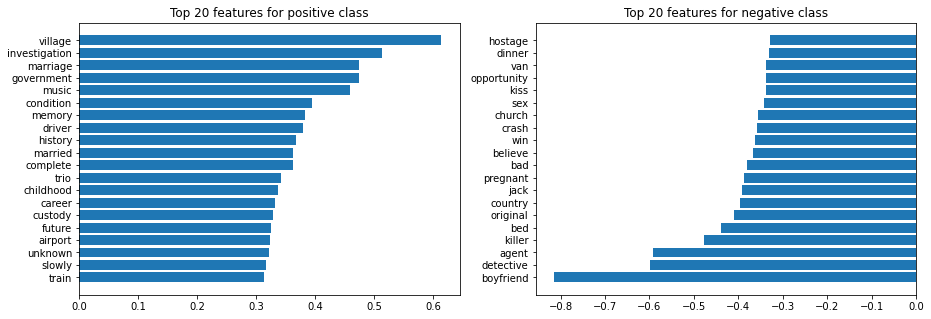

In [18]:
log_reg = LogisticRegression(class_weight = 'balanced')
log_reg.fit(X_train, y_train)
feat_imp = log_reg.coef_[0]
top20 = feat_imp.argsort()[-20:]
bottom20 = feat_imp.argsort()[:20]

fig, axs = plt.subplots(1,2, figsize = (15,5))
axs[0].barh(vectorizer.get_feature_names_out()[top20], feat_imp[top20])
axs[0].set_title("Top 20 features for positive class")

axs[1].barh(vectorizer.get_feature_names_out()[bottom20], feat_imp[bottom20])
axs[1].set_title("Top 20 features for negative class")

plt.show()

Some words are repeated from regression analysis like `village`, `government`, `investigation` and `memory`. There are also some new plot details related to relationships/drama `childhood`, `marriage`/`married`, `career` and `custody`. Interesting feature is `history`. We can suppose that historical movies are more likely to be rated highly.

Appearance of the following words in the movie plot makes the movie less likely to be rated highly: `boyfriend`, `pregnant`, `sex` and `kiss` - probably, melodramas; `detective`, `agent`, `killer`and `hostage` - seem to be describing action movies. 

### 4.2 Low rated movies

Let's try different approach to the classification problem and try identifying low rated movies (lower than 5.5)

In [19]:
y_bin = [1 if x <= 5.5 else 0 for x in y]
sum(y_bin)

4442

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, random_state = 1234, shuffle = True, stratify = y_bin)

print('Train sample size: '+str(len(y_train)))
print('Test sample size: '+str(len(y_test)))

Train sample size: 13542
Test sample size: 4515


In [21]:
vectorizer = CountVectorizer(ngram_range = (1,2), max_df = 4500, min_df = 550, binary=True, stop_words = 'english')
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
len(vectorizer.get_feature_names_out())

509

### 4.2.1 Naive Bayes

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameter: {'alpha': 0.1}
accuracy = 0.710, precision = 0.417, recall = 0.444, f1 = 0.430
accuracy = 0.703, precision = 0.396, recall = 0.395, f1 = 0.396


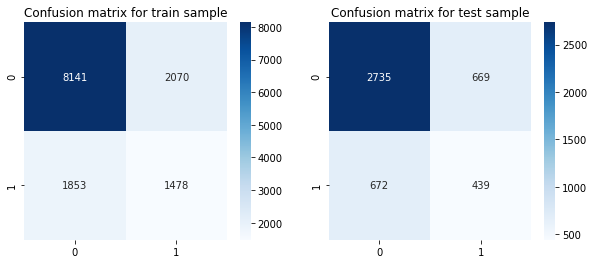

In [22]:
naive_b = BernoulliNB()

param_grid = {
    "alpha": [0.001, 0.01, 0.1, 1]
}

fit_class_model(naive_b, param_grid)

### 4.2.2 Logistic regression

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameter: {'C': 0.001}
accuracy = 0.653, precision = 0.377, recall = 0.630, f1 = 0.472
accuracy = 0.640, precision = 0.360, recall = 0.592, f1 = 0.448


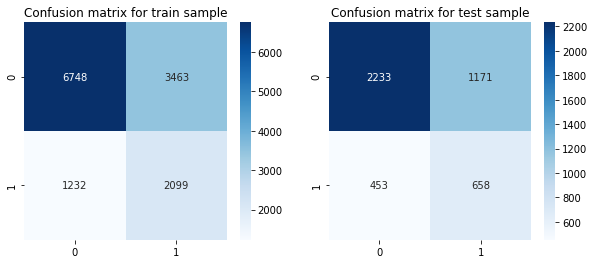

In [23]:
log_reg = LogisticRegression(class_weight = 'balanced')

param_grid = {
    "C": [0.001, 0.01, 0.1, 1]
}
fit_class_model(log_reg, param_grid)

### 4.2.3 Random forest classifier

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameter: {'max_depth': 300}
accuracy = 0.973, precision = 0.912, recall = 0.985, f1 = 0.947
accuracy = 0.739, precision = 0.307, recall = 0.050, f1 = 0.085


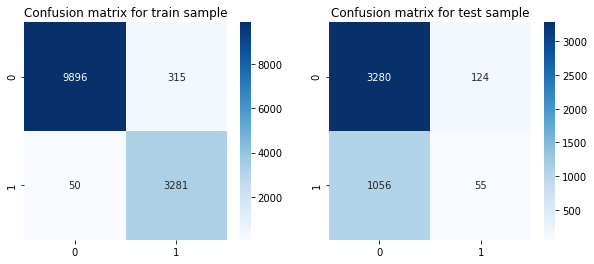

In [24]:
rfc = RandomForestClassifier(n_estimators = 200, class_weight = 'balanced')

param_grid = {
    "max_depth": [200, 300, 400]
}
fit_class_model(rfc, param_grid)

### 4.2.4 XGBoost classifier

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[01:04:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameter: {'max_depth': 200}
accuracy = 0.974, precision = 0.952, recall = 0.941, f1 = 0.946
accuracy = 0.723, precision = 0.374, recall = 0.188, f1 = 0.250


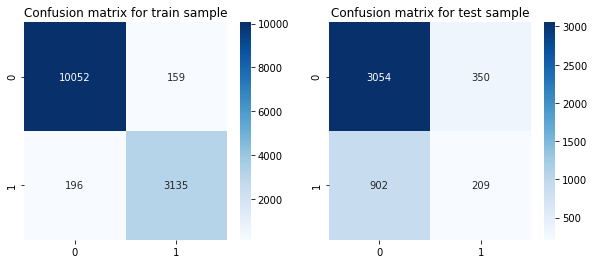

In [25]:
xgb = XGBClassifier(n_estimators = 200, subsample = 0.6)

param_grid = {
    "max_depth": [200, 300, 400]
}
fit_class_model(xgb, param_grid)

### 4.2.5 Important features

Once again, best recall estimate is given by logistic regression. 

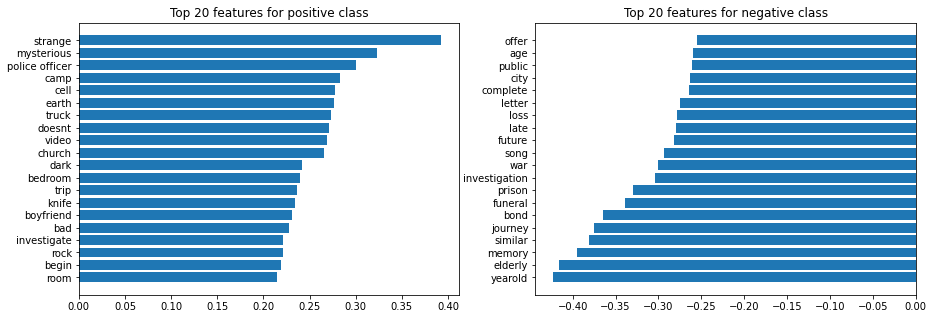

In [26]:
log_reg = LogisticRegression(class_weight = 'balanced')
log_reg.fit(X_train, y_train)
feat_imp = log_reg.coef_[0]
top20 = feat_imp.argsort()[-20:]
bottom20 = feat_imp.argsort()[:20]

fig, axs = plt.subplots(1,2, figsize = (15,5))
axs[0].barh(vectorizer.get_feature_names_out()[top20], feat_imp[top20])
axs[0].set_title("Top 20 features for positive class")

axs[1].barh(vectorizer.get_feature_names_out()[bottom20], feat_imp[bottom20])
axs[1].set_title("Top 20 features for negative class")

plt.show()

Among the words we have already seen are `strange`, `mysterious`, `church` and `boyfriend`. The first three words seem to be describing horro movies which are often low rated. For not low rated movies, we can indicate `future`, `journey`, `funeral`, `memory`, `prison`, `investigation` and `war`. These words were seen in the linear regression section of the analysis.

## Conclusion

From this analysis, we can make some conclusions like: movies about mysterious and strange events are more likely to be rated low, while historical dramas and thrillers involving government, prison and funerals have more chances to be positively accepted by the audience. 

Surely, to be more accurate with rating prediction we need more features like cast, director and genre, but we had different goal. There is a large room for improvement like scraping more data, more detailed plot description (not wikipedia), adding series description. It would also be of interest to apply deep learning models to this problem. 